In [1]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [72]:
import numpy as np
import scipy.io as sio
df = sio.loadmat('snelson1d.mat')

In [73]:
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [74]:
X1 = X[np.argsort(X, axis=0)]
Y1 = Y[np.argsort(X, axis=0)] 
X1 = X1.reshape(-1,1)
Y1 = Y1.reshape(-1,1)


### Code

In [81]:
print(X.min())
print(X.max())


0.059167804
5.9657729


In [82]:
N_star = 20
X_star = np.linspace(-0.5, 6.5, N_star)[:, None]

In [83]:
intervals = [(0.75,1.25), (2.5, 3.0), (4.25, 4.75)]

In [88]:
X_train, Y_train = X1.copy(), Y1.copy()
X_test, Y_test = [], [] 
test_indices = []

In [89]:
for a, b in intervals:
    indices = list(np.where(np.logical_and(X1.flatten() > a, X1.flatten() < b))[0] )
    if test_indices is None:
        test_indices = indices
    else:
        test_indices = test_indices + indices
#     print(test_indices)
# print(test_indices)
train_indices = np.arange(X.shape[0])
test_indices = np.asarray(test_indices)
train_indices = np.setdiff1d(train_indices, test_indices)
X_test, Y_test = X1[test_indices,:], Y1[test_indices]
X_train, Y_train = X1[train_indices,:], Y1[train_indices]


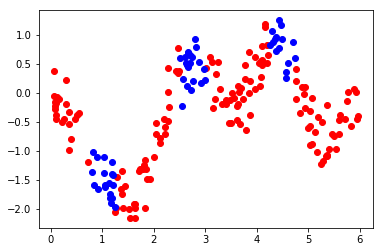

In [91]:
plt.plot(X_train, Y_train, 'ro')
plt.plot(X_test, Y_test, 'bo')

In [97]:
stan_code_pred = """
functions{
    vector gp_pred_rng(real[] x, vector y, real[] x_star, real alpha, real rho, real sigma, real jitter){
        
        int N = rows(y);
        int N_star = size(x_star);
        vector[N_star] f_star;
        {
            matrix[N, N] Kff = cov_exp_quad(x, alpha, rho) + diag_matrix(rep_vector(square(sigma), N));
            matrix[N, N] L_K = cholesky_decompose(Kff);
            
            vector[N] L_K_div_y = mdivide_left_tri_low(L_K, y);    #forward substitution
            vector[N] K_div_y = mdivide_right_tri_low(L_K_div_y', L_K)';   #backward substitiion

            matrix[N_star, N] K_star_f = cov_exp_quad(x_star, x, alpha, rho);
            matrix[N_star, N_star] K_star_star = cov_exp_quad(x_star, x_star, alpha, rho);
            matrix[N, N_star] v = mdivide_left_tri_low(L_K, K_star_f');
            vector[N_star] f_star_mean = K_star_f*K_div_y;
            matrix[N_star, N_star] f_star_cov = K_star_star - v'*v + diag_matrix(rep_vector(square(jitter), N_star));
            
            f_star = multi_normal_rng(f_star_mean, f_star_cov);
        }
        return f_star;
    }
}

data {
    int<lower=1> N;
    int<lower=1> N_star;
    real x[N];
    real x_star[N_star];
    vector[N] y;
}

transformed data {
    real jitter = 1e-6;
#     real rho = 1;
#     real alpha = 1;
}

parameters {
#     vector[N] f;    
    real<lower=1e-6> sigma;
    real <lower=1e-4> alpha;
    real<lower=1e-4> rho;
    
    vector[N] eta;
}

model {
    vector[N] f_mean;
    matrix[N, N] f_cov;
    matrix[N, N] A;
    matrix[N, N] diff;
    vector[N] f;
    
    {
        matrix[N, N] K = cov_exp_quad(x, alpha, rho) + diag_matrix(rep_vector(square(sigma), N));
        
        matrix[N, N] L_K = cholesky_decompose(K);
        f = L_K *eta ;
        
    }
    
    rho ~ normal(0.90, 0.50);
    alpha ~ normal(0.85, 0.50);

    sigma ~ normal(0, 1.0);
    eta ~ normal(0, 1);
#     f ~ multi_normal_cholesky(f_mean, L_K);
#     y ~ multi_normal_cholesky(f_mean,  L_K)
    y ~ normal(f, sigma);
    
}

generated quantities{
    vector[N_star] f_star = gp_pred_rng(x, y, x_star, alpha, rho, sigma, jitter); 
#     vector[N_star] y_star = normal_rng(f_star, sigma);
    vector[N_star] y_star;
    for (i in 1:N_star){
        y_star[i] = normal_rng(f_star[i], sigma);
    }
    
}

"""

In [93]:
print(X_test.shape)
print(X_train.shape)


(55, 1)
(145, 1)


In [98]:
stan_model_snelson_pred= pystan.StanModel(model_code=stan_code_pred)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_25b3edf89d55d55dee0368de6310fbdf NOW.


In [94]:
N_star = X_test.shape[0]
N = X_train.shape[0]

In [96]:
gp_reg_data_imp = {'N':N, 'x':X_train.flatten(), 'y':Y_train.flatten(),  'N_star':N_star, 'x_star':X_test.flatten()}

In [100]:
fit_gp_pred_snelson = stan_model_snelson_pred.sampling(data=gp_reg_data_imp, iter=600, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [106]:
samples = fit_gp_pred_snelson.extract(permuted=True)
eta_samples = samples['eta']
eta_mean = np.mean(eta_samples, axis=0)
sigma_samples = samples['sigma']
sigma_mean = np.mean(sigma_samples, axis=0)
alpha_samples = samples['alpha']
alpha_mean = np.mean(alpha_samples, axis=0)
rho_samples = samples['rho']
f_star_samples = samples['f_star']
y_star_samples = samples['y_star']
f_star_mean = np.mean(f_star_samples, axis=0)
y_star_mean = np.mean(y_star_samples, axis=0)
f_star_var = np.var(f_star_samples, axis=0)
y_star_var = np.var(y_star_samples, axis=0)

In [118]:
print(y_star_var)
print(f_star_var)

[0.05904327 0.06324225 0.05815633 0.06036897 0.06023672 0.05534311
 0.06183519 0.05789723 0.0523216  0.05463188 0.05798123 0.05803767
 0.05437723 0.05423576 0.05314269 0.05618182 0.05070301 0.04829599
 0.04758426 0.05033523 0.05451535 0.05668947 0.0541814  0.05907894
 0.04967885 0.05693714 0.05956629 0.0546552  0.05507447 0.05532449
 0.04828753 0.05264923 0.05253385 0.05849789 0.05302726 0.05321027
 0.05527533 0.04767439 0.05584346 0.05429084 0.04597727 0.05272308
 0.05144453 0.05256801 0.05456798 0.05034119 0.05430848 0.04866945
 0.05227488 0.05488331 0.05392335 0.04763665 0.05266733 0.05440404
 0.04917427]
[0.01593426 0.01634511 0.01664804 0.01735282 0.01731016 0.01542833
 0.01502521 0.01484033 0.01435555 0.01123792 0.01113514 0.01093686
 0.01031747 0.00905838 0.0090369  0.00896192 0.00816977 0.0081439
 0.0072235  0.00765088 0.00849509 0.00941952 0.01007013 0.01090582
 0.01106996 0.01130118 0.01161155 0.011629   0.01165011 0.01209399
 0.01213216 0.01226119 0.01231556 0.01232049 0.012

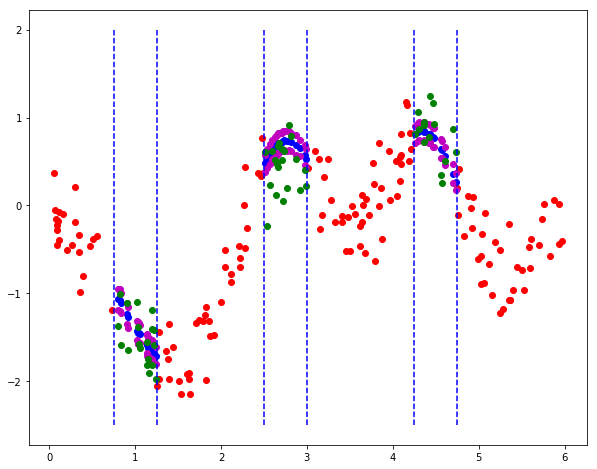

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
ax.plot(X_train ,Y_train, 'ro')
ax.plot(X_test, y_star_mean, 'bo')
ax.plot(X_test, y_star_mean + 2*y_star_var, 'mo')
ax.plot(X_test, y_star_mean - 2*y_star_var, 'mo')
ax.plot(X_test, Y_test, 'go')
for i in intervals:
    ax.plot([i[0], i[0]], [-2.5, 2], 'b--')
    ax.plot([i[1], i[1]], [-2.5, 2], 'b--')

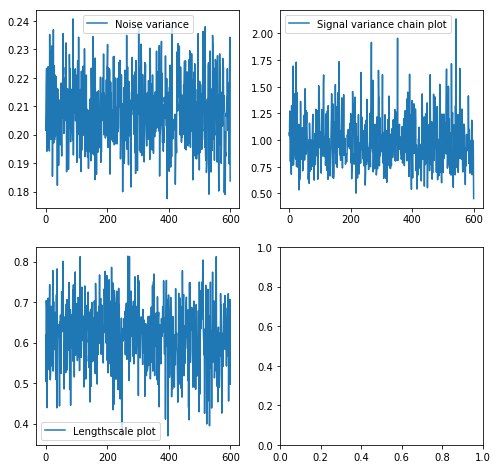

In [108]:
fig, axes = plt.subplots(2,2, figsize=(8,8))

axes[0,0].plot(sigma_samples)
axes[0,0].legend(['Noise variance'])
axes[0,1].plot(alpha_samples)
axes[0,1].legend(['Signal variance chain plot'])
axes[1,0].plot(rho_samples)
axes[1,0].legend(['Lengthscale plot'])



In [123]:

def RMSE(Y_star, Y_test):
    rmse = np.sqrt(np.mean(np.square(Y_star - Y_test)))
    return rmse

def NMSE(Y_star, Y_test):
    nmse = np.mean(np.square(Y_star - Y_test)) / np.mean(np.square(Y_test - np.mean(Y_test)))
    return nmse

def MLPPD(Y_star, Y_test, var_star):
    mlppd = 0.5* (np.sum(np.square(Y_star - Y_test)/var_star + np.log(var_star) + np.log(2*np.pi))) / Y_star.size
    return mlppd

def MLPPD2(Y_star, Y_test, var_star):
    mlppd2 = 0.5* (np.sum(np.square(Y_star - Y_test)/(var_star*np.abs(Y_test)) + np.log(var_star) + np.log(2*np.pi))) / Y_star.size
    return mlppd2


In [127]:
RMSE_test_f = RMSE(f_star_mean, Y_test)
RMSE_test = RMSE(y_star_mean, Y_test)
NMSE_test_f = NMSE(f_star_mean, Y_test)
MLPPD_test1 = MLPPD(y_star_mean, Y_test, y_star_var)
# MLPPD_test2 = MLPPD(y_star_mean, Y_test, y_star_var)
MLPPD_test2 = MLPPD2(y_star_mean, Y_test, y_star_var)
print("RMSE error: %.3f"%RMSE_test)
print("NMSE error: %.3f"%NMSE_test)

print("MLPPD error: %.3f"%MLPPD_test1)
print("MLPPD2 error: %.3f"%MLPPD_test2)

RMSE error: 1.478
NMSE error: 1.989
MLPPD error: 1085.436
MLPPD2 error: 1587.536


In [115]:
print(y_star_mean)
print(Y_test)

[-1.06845628 -1.07782572 -1.10969533 -1.2328318  -1.27193624 -1.42403709
 -1.45246378 -1.45475226 -1.46571208 -1.57409733 -1.59429821 -1.62061205
 -1.62082596 -1.64543767 -1.65504692 -1.67077434 -1.68744995 -1.68827423
 -1.70942914  0.47768062  0.53635103  0.5893236   0.63404815  0.66497669
  0.69398103  0.69001232  0.70809409  0.7081039   0.71414255  0.7270041
  0.72587859  0.73590213  0.73971903  0.73451846  0.73530431  0.72306332
  0.6896626   0.65277321  0.57049485  0.52875912  0.80765443  0.83356703
  0.85135477  0.82985933  0.84292222  0.8425861   0.81540623  0.81364931
  0.77378528  0.76899139  0.64433531  0.63585306  0.56211761  0.36298199
  0.27072464]
[[-1.3704895 ]
 [-1.011783  ]
 [-1.5898677 ]
 [-1.1101869 ]
 [-1.6510072 ]
 [-1.103029  ]
 [-1.3804133 ]
 [-1.5803886 ]
 [-1.6191998 ]
 [-1.5560383 ]
 [-1.8112513 ]
 [-1.7473682 ]
 [-1.9023357 ]
 [-1.1922887 ]
 [-1.4049308 ]
 [-1.8111369 ]
 [-1.5914154 ]
 [-1.4197883 ]
 [-1.9706934 ]
 [ 0.60504345]
 [-0.23416586]
 [ 0.23281771]
